# EEG to ECG Reconstruction


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from lib.gpr_utils import train_pulse
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from lib.utils import seed_everything
from lib.plot_utils import visualize_ecg_and_peaks, plot_augmentation_example, plot_train_hystory, visualize_predictions
from lib.dataset_utils import create_segments_sliding, create_training_segments_with_augmentation, create_segments_nonoverlapping, augment_segment
from lib.train_utils import evaluate_loader, subject_mae
from scipy.signal import butter, sosfiltfilt

seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pytorch version: 2.7.1+cu126
CUDA version: 12.6
Tesla T4
Using device: cuda


In [ ]:
# Configuration
A = 2              # Amplitude of the train pulses
width = 0.05       # Width of each pulse
tau = 5            # Lag (downsampling factor)
duration_sec = 10  # segment length

# Available subjects
subj_all = [29, 41, 30, 40, 23, 27, 28, 39]
test_subj = subj_all[0]
val_subj = subj_all[1]
train_subjects = [s for s in subj_all if s not in (test_subj, val_subj)]

# Pulse type for ECG transformation Gaussian or Rectangular
impulse = "Gaussian"

# Augmentation settings
use_augmentation = True
warp_factor_range = (0.85, 1.15)
aug_segment_duration = round(warp_factor_range[1] * duration_sec)       # seconds (larger than target to allow warping)
n_augmented_per_segment = 5

# Training settings
train_overlap = 0.9
batch_size = 16
learning_rate = 1e-3
epochs = 100
patience = 40

# Paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
parsed_path = os.path.join(cache_dir, "data_parsed.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed.pkl")

# Heart-rate band filtering (~1 Hz)
use_hr_band_filter = True
lowcut=0.1
highcut=16

# Use only the first N seconds of each subject (after downsampling)
dataset_max_seconds = 1000

## Load, Parse and Preprocess

Loaded parsed and preprocess data from cache


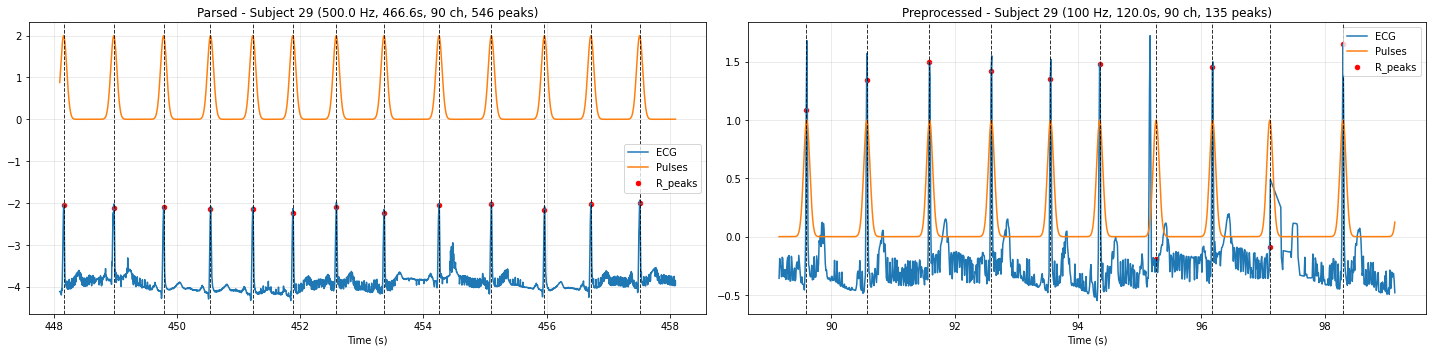

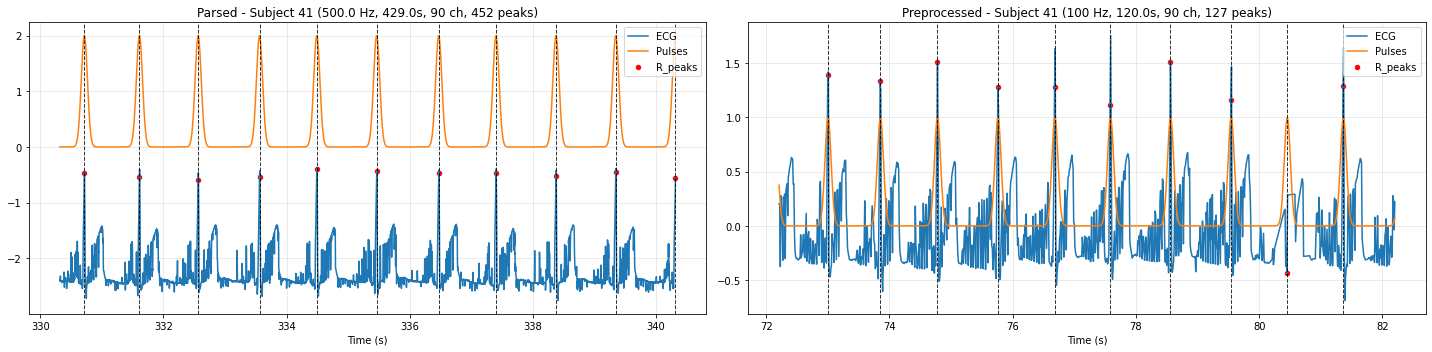

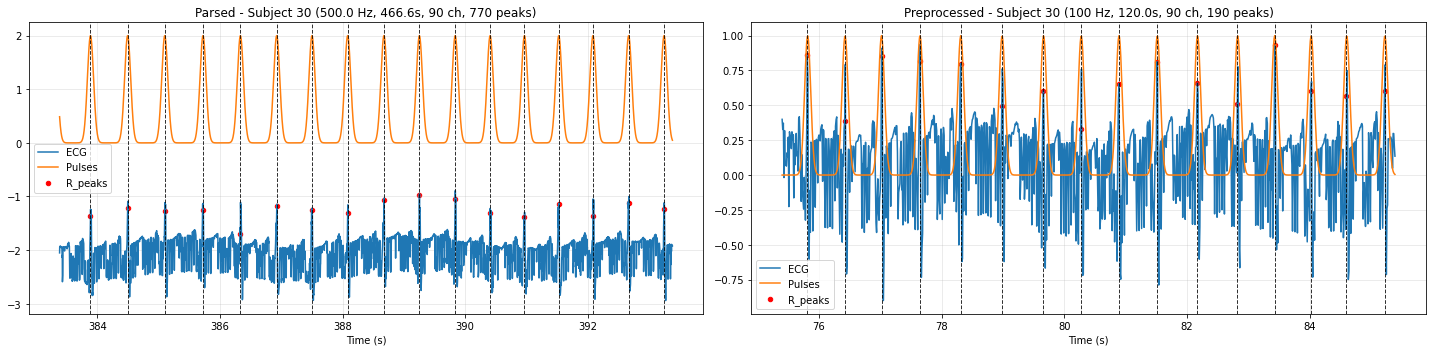

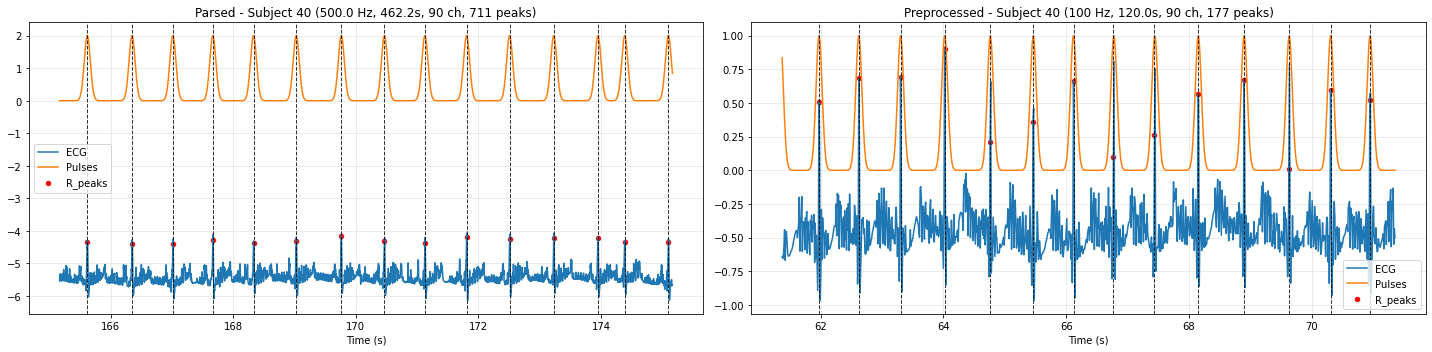

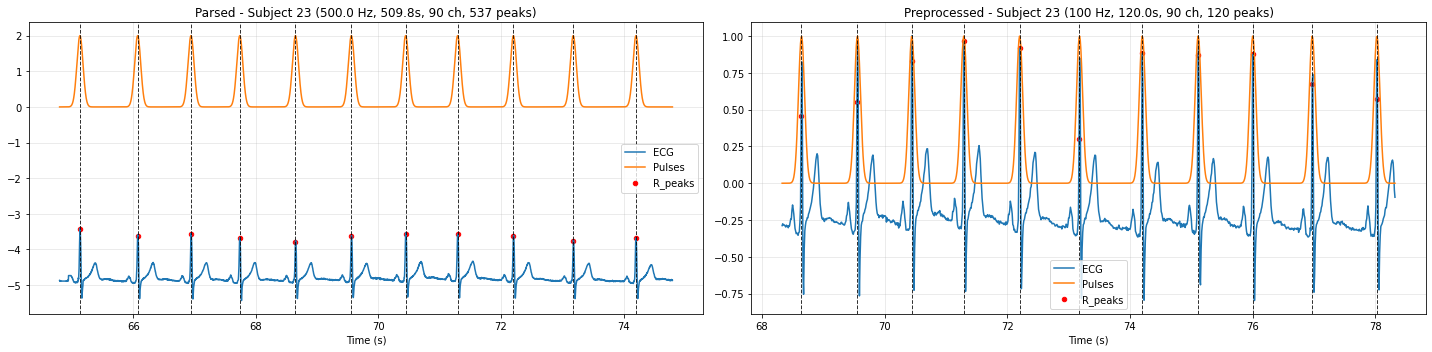

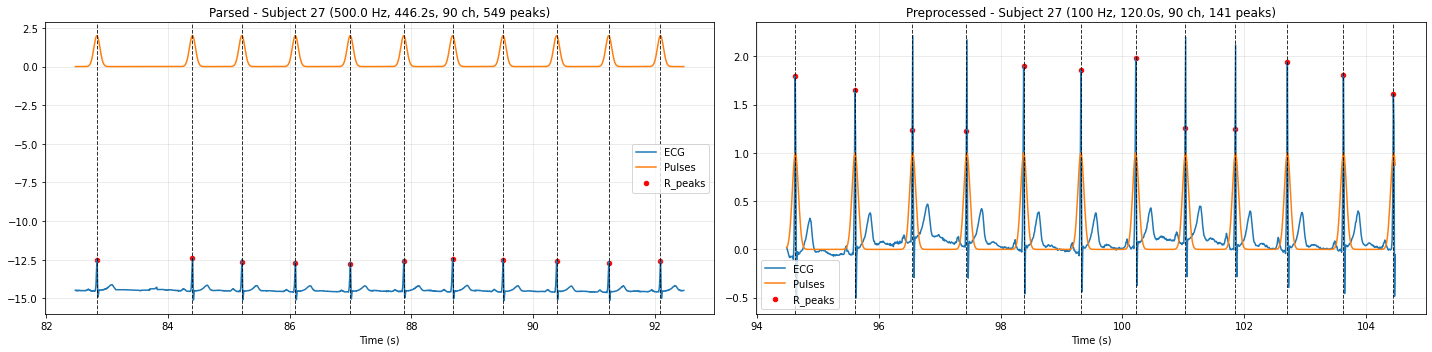

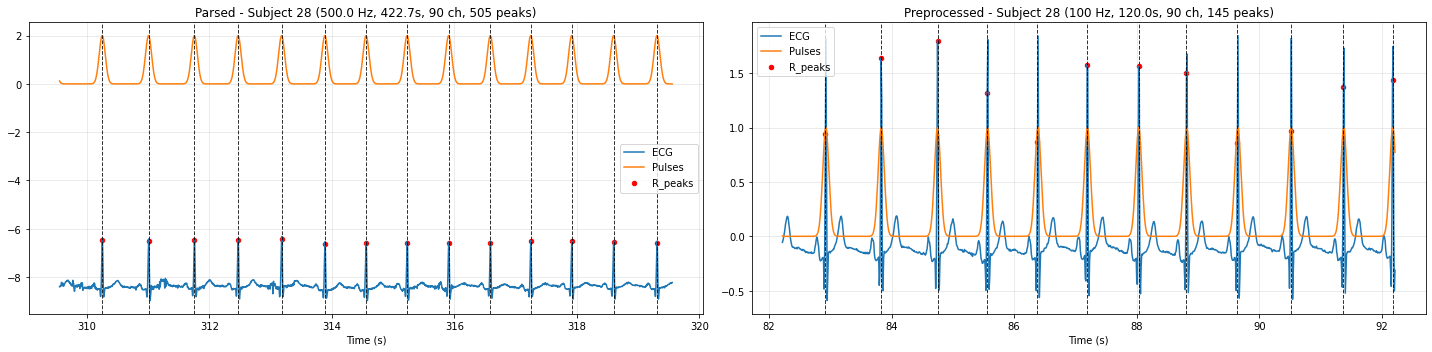

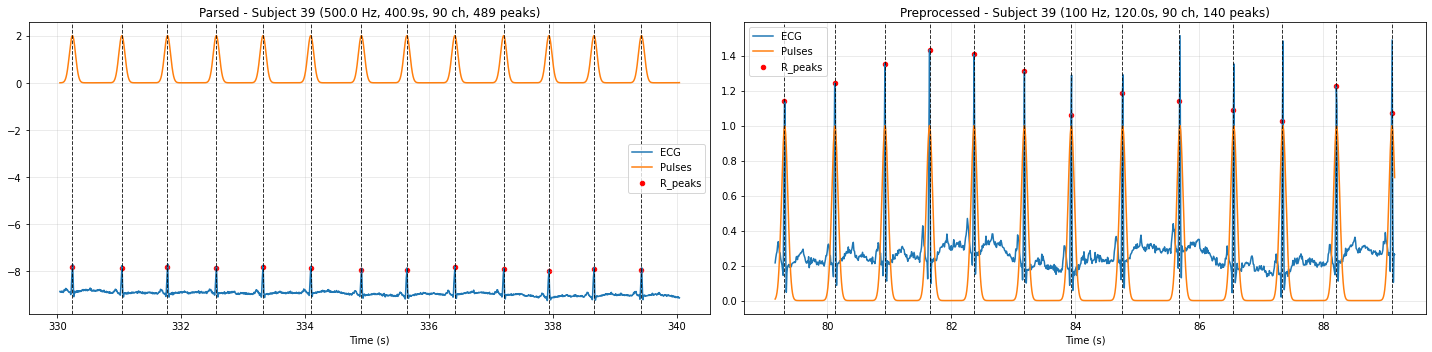

In [4]:
def load_subject_data(subj_id, A, width, impulse):
    """Load and parse data for a single subject."""
    # Load preprocessed EEG
    data = loadmat(f'Signals/P0{subj_id:02d}_prepro.mat')
    EEG_prepro = data['EEG_prepro']
    Y_prepro = EEG_prepro['data'][0, 0].astype(float)
    freq_prepro = float(EEG_prepro['srate'][0, 0])

    # Load ECG
    ecg_data = loadmat(f'Signals/P0{subj_id:02d}.mat')
    t_prepro = ecg_data["t_int"].flatten()
    t_prepro = np.insert(t_prepro, 0, 0.0)

    R_peak = ecg_data['R_peak'].flatten() - 1
    ECG = ecg_data['ECG_i'].flatten()
    ECG = np.insert(ECG, len(ECG), ECG[-1])

    # Generate pulse train
    ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulse)

    return { 'ECG': ECG, 'ECG_pulse': ECG_pulse, 'R_peaks': R_peak, 'EEG': Y_prepro, 'time': t_prepro, 'freq': freq_prepro }


def bandpass_eeg(x, fs, lowcut=0.1, highcut=22.5, order=4):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=-1)


def preprocess_subject_data(subject_data, tau):
    """Normalize and downsample subject data."""
    ECG = subject_data['ECG'].copy() - np.mean(subject_data['ECG'])
    ECG = ECG[::tau]  # downsample

    ECG_pulse = minmax_scale(subject_data['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
    ECG_pulse = ECG_pulse[::tau]

    EEG = minmax_scale(subject_data['EEG'].copy(), feature_range=(0, 1), axis=1)
    EEG = EEG - np.mean(EEG, axis=1, keepdims=True)  # Subtract per channel mean

    # Compute downsampled frequency
    freq = int(subject_data['freq'] / tau)

    # Downsample EEG
    EEG = EEG[:, ::tau]

    R_peaks = subject_data['R_peaks'].copy() // tau
    time = subject_data['time'].copy()[::tau]

    return {
        'ECG': ECG,
        'ECG_pulse': ECG_pulse,
        'R_peaks': R_peaks,
        'EEG': EEG,
        'time': time,
        'freq': freq
    }

# Load parsed data
if os.path.exists(parsed_path) and os.path.exists(preproc_path):
    with open(parsed_path, "rb") as f:
        data_parsed = pickle.load(f)
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded parsed and preprocess data from cache")
else:
    print("Loading and parsing raw data...")
    data_parsed = {}
    data_preprocessed = {}
    for ss in subj_all:
        print(f"  Loading subject {ss}...")
        data_parsed[ss] = load_subject_data(ss, A, width, impulse)
        data_preprocessed[ss] = preprocess_subject_data(data_parsed[ss], tau)
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved to {parsed_path}")
    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved to {preproc_path}")

# Apply HR band-pass AFTER loading (works with PKL cache)
if use_hr_band_filter:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        eeg_unfilt = np.asarray(data_preprocessed[ss]['EEG'], dtype=float)
        data_preprocessed[ss]['EEG_unfilt'] = eeg_unfilt
        data_preprocessed[ss]['EEG'] = bandpass_eeg(eeg_unfilt, fs_ds, lowcut=lowcut, highcut=highcut)

# Trim all signals to the first dataset_max_seconds seconds
if dataset_max_seconds is not None:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        max_samples = int(dataset_max_seconds * fs_ds)
        # Bound against available length
        T = data_preprocessed[ss]['EEG'].shape[1]
        max_samples = min(max_samples, T)

        # Slice time-series
        data_preprocessed[ss]['EEG'] = data_preprocessed[ss]['EEG'][:, :max_samples]
        if 'EEG_unfilt' in data_preprocessed[ss]:
            data_preprocessed[ss]['EEG_unfilt'] = data_preprocessed[ss]['EEG_unfilt'][:, :max_samples]
        data_preprocessed[ss]['ECG'] = data_preprocessed[ss]['ECG'][:max_samples]
        data_preprocessed[ss]['ECG_pulse'] = data_preprocessed[ss]['ECG_pulse'][:max_samples]
        data_preprocessed[ss]['time'] = data_preprocessed[ss]['time'][:max_samples]

        # Keep R-peaks within the window
        rps = np.asarray(data_preprocessed[ss]['R_peaks'])
        data_preprocessed[ss]['R_peaks'] = rps[rps < max_samples]

# Visualize parsed data
for ss in subj_all:
    visualize_ecg_and_peaks(ss, data_parsed[ss], data_preprocessed[ss], duration_sec)

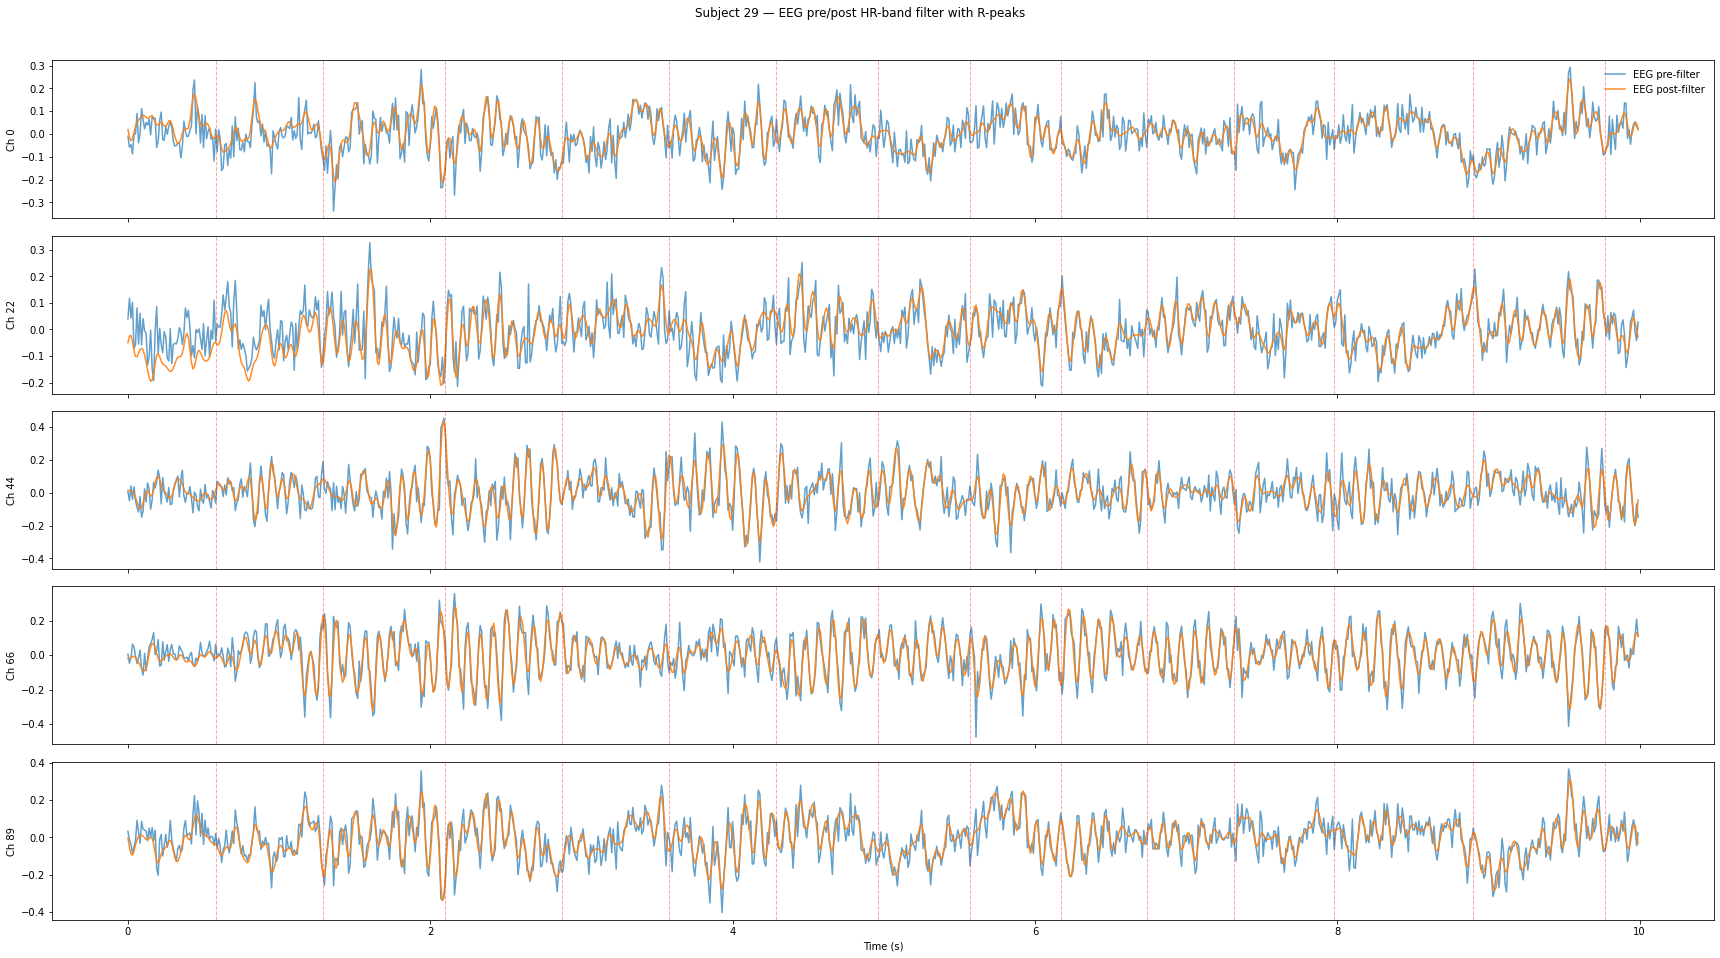

In [5]:
# EEG pre/post-filter visualization with R-peaks (5 channels) + residual and metrics
plot_subj = test_subj  # subject to visualize

pre_ds = data_preprocessed[plot_subj].get('EEG_unfilt', None)
post_ds = data_preprocessed[plot_subj]['EEG']
fs_ds = data_preprocessed[plot_subj]['freq']
rpeaks_ds = data_preprocessed[plot_subj]['R_peaks']

# Reconstruct pre-filter downsampled EEG if not present in cache
if pre_ds is None:
    raw = data_parsed[plot_subj]['EEG'].copy()  # (C, T_full)
    raw = minmax_scale(raw, feature_range=(0, 1), axis=1)
    raw = raw - np.mean(raw, axis=1, keepdims=True)
    pre_ds = raw[:, ::tau]

n_channels = pre_ds.shape[0]
n_samp = min(int(duration_sec * fs_ds), pre_ds.shape[1])  # plot up to duration_sec
t = np.arange(pre_ds.shape[1]) / fs_ds

# Select 5 channels evenly across the montage
n_plot = 5
chan_idx = np.linspace(0, n_channels - 1, n_plot, dtype=int)
fig, axes = plt.subplots(n_plot, 1, figsize=(24, 2.6 * n_plot), sharex=True)

for i, ch in enumerate(chan_idx):
    ax = axes[i]
    y0 = pre_ds[ch, :n_samp]
    y1 = post_ds[ch, :n_samp]

    ax.plot(t[:n_samp], y0, label='EEG pre-filter', color='C0', alpha=0.7)
    ax.plot(t[:n_samp], y1, label='EEG post-filter', color='C1', alpha=0.9)

    # R-peak vertical lines (downsampled indices)
    for rp in rpeaks_ds:
        if 0 <= rp < n_samp:
            ax.axvline(t[rp], color='r', linestyle='--', alpha=0.35, linewidth=1)
    ax.set_ylabel(f"Ch {ch}")
    if i == 0:
        ax.legend(loc='upper right', frameon=False)

axes[-1].set_xlabel('Time (s)')
fig.suptitle(f'Subject {plot_subj} — EEG pre/post HR-band filter with R-peaks', y=1.02)
plt.tight_layout()
plt.show()

## Segmentation and Train/Val/Test Split

In [40]:
downsampled_frequency = data_preprocessed[subj_all[0]]['freq']
seg_len = int(duration_sec * downsampled_frequency)
aug_seg_len = int(aug_segment_duration * downsampled_frequency) if use_augmentation else seg_len
train_stride = max(1, int(seg_len * (1.0 - train_overlap)))
n_channels = data_preprocessed[subj_all[0]]['EEG'].shape[0]

print(f"Test subject: {test_subj} | Val subject: {val_subj} | Train subject: {train_subjects}")
print(f"Frequency: {downsampled_frequency} Hz | Segment length: {seg_len} samples ({duration_sec}s)")
print(f"Train overlap: {train_overlap:.2f}")

if use_augmentation:
    print(f"Augmentation: {n_augmented_per_segment}x per segment")
    print(f"Warp range: {warp_factor_range}")

Test subject: 29 | Val subject: 41 | Train subject: [30, 40, 23, 27, 28, 39]
Frequency: 100 Hz | Segment length: 1000 samples (10s)
Train overlap: 0.90
Augmentation: 5x per segment
Warp range: (0.85, 1.15)


In [41]:
X_train_list, y_train_list, ecg_train_list, train_ids_list = [], [], [], []

for s in train_subjects:
    print(f"Processing training subject {s}...", end="")
    
    if use_augmentation:
        X_s, y_s, ecg_s = create_training_segments_with_augmentation(
            data_preprocessed[s], aug_seg_len, seg_len, train_stride,
            warp_factor_range, n_augmented_per_segment
        )
        print(f"  Created {X_s.shape[0]} segments (with augmentation)")
    else:
        X_s, y_s, ecg_s = create_segments_sliding(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            data_preprocessed[s]['ECG'],
            seg_len, train_stride
        )
        print(f"  Created {X_s.shape[0]} segments")
    
    X_train_list.append(X_s)
    y_train_list.append(y_s)
    ecg_train_list.append(ecg_s)
    train_ids_list.append(np.full((X_s.shape[0],), s, dtype=np.int32))

# Build validation set (non-overlapping)
print(f"\nProcessing validation subject {val_subj}...", end="")
X_val, y_val, ECG_val = create_segments_nonoverlapping(
    data_preprocessed[val_subj]['EEG'],
    data_preprocessed[val_subj]['ECG_pulse'],
    data_preprocessed[val_subj]['ECG'],
    seg_len
)
print(f"  Created {X_val.shape[0]} segments")

# Build test set (non-overlapping)
print(f"Processing test subject {test_subj}...", end="")
X_test, y_test, ECG_test = create_segments_nonoverlapping(
    data_preprocessed[test_subj]['EEG'],
    data_preprocessed[test_subj]['ECG_pulse'],
    data_preprocessed[test_subj]['ECG'],
    seg_len
)
print(f"  Created {X_test.shape[0]} segments")

# Concatenate training data
X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.empty((0, seg_len, n_channels))
y_train = np.concatenate(y_train_list, axis=0) if y_train_list else np.empty((0, seg_len))
ECG_train = np.concatenate(ecg_train_list, axis=0) if ecg_train_list else np.empty((0, seg_len))
train_seg_subjects = np.concatenate(train_ids_list, axis=0) if train_ids_list else np.empty((0,), dtype=np.int32)

print(f"\nFinal dataset:")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")

Processing training subject 30...

  Created 660 segments (with augmentation)
Processing training subject 40...  Created 660 segments (with augmentation)
Processing training subject 23...  Created 660 segments (with augmentation)
Processing training subject 23...  Created 660 segments (with augmentation)
Processing training subject 27...  Created 660 segments (with augmentation)
Processing training subject 27...  Created 660 segments (with augmentation)
Processing training subject 28...  Created 660 segments (with augmentation)
Processing training subject 28...  Created 660 segments (with augmentation)
Processing training subject 39...  Created 660 segments (with augmentation)
Processing training subject 39...  Created 660 segments (with augmentation)

Processing validation subject 41...  Created 12 segments
Processing test subject 29...  Created 12 segments
  Created 660 segments (with augmentation)

Processing validation subject 41...  Created 12 segments
Processing test subject 29...  Created 12 segments

Final datas

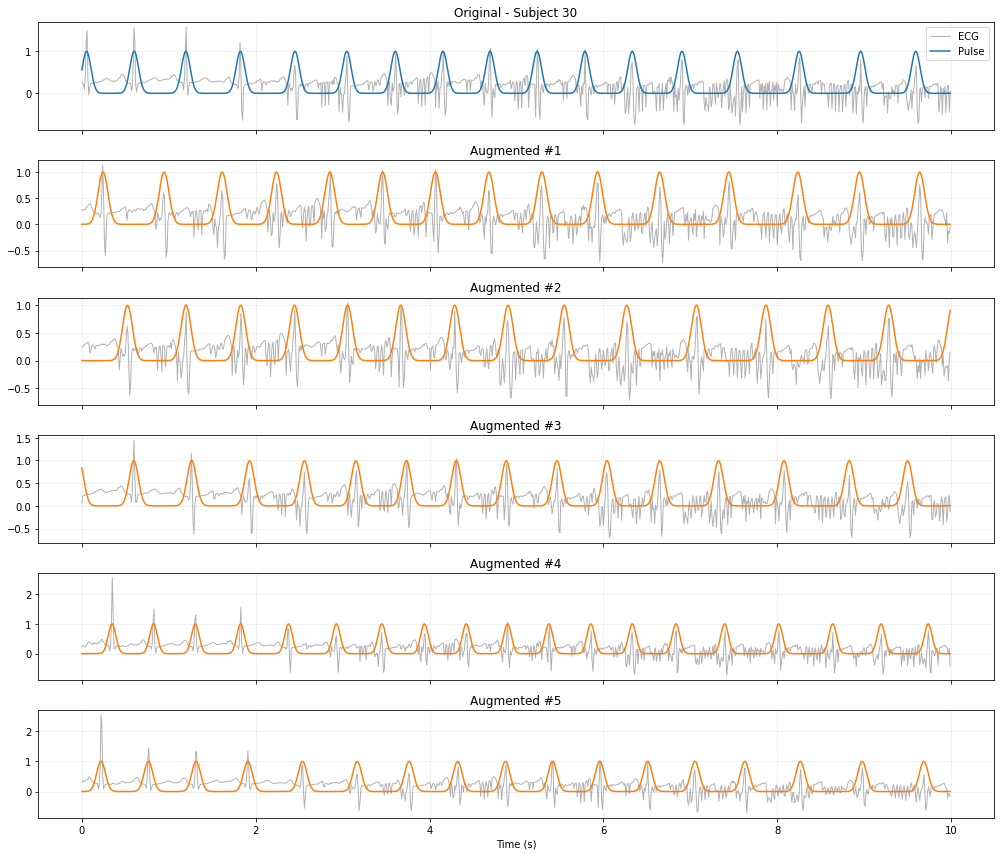

In [42]:
# Visualize augmentation example
if use_augmentation and len(train_subjects) > 0:
    demo_subj = train_subjects[0]
    plot_augmentation_example(data_preprocessed, demo_subj, aug_seg_len, seg_len, warp_factor_range, downsampled_frequency)

In [43]:
# Create PyTorch datasets and loaders
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Created data loaders with training batch_size={batch_size}")

Created data loaders with training batch_size=16


## Model Definition

In [44]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()

    def forward(self, x):
        return self.dropout(self.net(x))


class UNet1D(nn.Module):
    def __init__(self, in_ch, base_ch=32, out_ch=1, dropout=0.2):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_ch, base_ch, dropout)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2, dropout)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4, dropout)
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_ch * 4, base_ch * 8, dropout)

        # Decoder
        self.up3 = nn.ConvTranspose1d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4, dropout)
        self.up2 = nn.ConvTranspose1d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2, dropout)
        self.up1 = nn.ConvTranspose1d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch, dropout)

        self.out_conv = nn.Conv1d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (B, T, C) -> (B, C, T)
        
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        out = self.out_conv(d1)  # (B, 1, T)
        return out.squeeze(1)  # (B, T)


model = UNet1D(in_ch=n_channels, base_ch=8, out_ch=1, dropout=0.5).to(device)

summary(model, input_size=(1, seg_len, n_channels), col_names=["input_size", "output_size", "num_params"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet1D                                   [1, 1000, 90]             [1, 1000]                 --
├─ConvBlock: 1-1                         [1, 90, 1000]             [1, 8, 1000]              --
│    └─Sequential: 2-1                   [1, 90, 1000]             [1, 8, 1000]              --
│    │    └─Conv1d: 3-1                  [1, 90, 1000]             [1, 8, 1000]              2,168
│    │    └─BatchNorm1d: 3-2             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-3                    [1, 8, 1000]              [1, 8, 1000]              --
│    │    └─Conv1d: 3-4                  [1, 8, 1000]              [1, 8, 1000]              200
│    │    └─BatchNorm1d: 3-5             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-6                    [1, 8, 1000]              [1, 8, 1000]              --
│    └─Dropout: 2-2            

## Training

Starting training...
Epoch 01 - train: 0.23410, val: 0.21084, test: 0.20917
Epoch 01 - train: 0.23410, val: 0.21084, test: 0.20917
Epoch 02 - train: 0.21629, val: 0.21948, test: 0.21665
Epoch 02 - train: 0.21629, val: 0.21948, test: 0.21665
Epoch 03 - train: 0.20368, val: 0.20707, test: 0.20260
Epoch 03 - train: 0.20368, val: 0.20707, test: 0.20260
Epoch 04 - train: 0.17559, val: 0.18140, test: 0.18582
Epoch 04 - train: 0.17559, val: 0.18140, test: 0.18582
Epoch 05 - train: 0.15857, val: 0.17876, test: 0.18696
Epoch 05 - train: 0.15857, val: 0.17876, test: 0.18696
Epoch 06 - train: 0.14972, val: 0.17235, test: 0.18310
Epoch 06 - train: 0.14972, val: 0.17235, test: 0.18310
Epoch 07 - train: 0.14487, val: 0.17811, test: 0.18599
Epoch 07 - train: 0.14487, val: 0.17811, test: 0.18599
Epoch 08 - train: 0.14087, val: 0.17832, test: 0.18977
Epoch 08 - train: 0.14087, val: 0.17832, test: 0.18977
Epoch 09 - train: 0.13680, val: 0.17188, test: 0.18686
Epoch 09 - train: 0.13680, val: 0.17188, tes

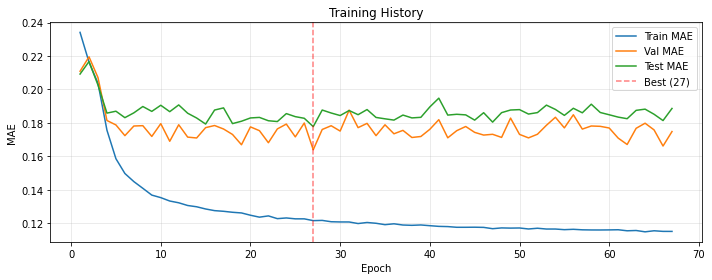

In [45]:
from lib.train_utils import check_early_stopping


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_mae_hist, val_mae_hist, test_mae_hist = [], [], []
best_val = float('inf')
best_state = None
wait = 0
best_epoch = 0

print("Starting training...")
for epoch in range(1, epochs + 1):
    # Train
    model.train()
    train_loss, train_mae, n_batches = 0.0, 0.0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += (pred.detach() - yb).abs().mean().item()
        n_batches += 1
    
    train_loss /= n_batches
    train_mae /= n_batches

    # Evaluate
    val_loss, val_mae = evaluate_loader(model, val_loader, device, criterion)
    test_loss, test_mae = evaluate_loader(model, test_loader, device, criterion)

    # Log
    train_mae_hist.append(train_mae)
    val_mae_hist.append(val_mae)
    test_mae_hist.append(test_mae)
    print(f"Epoch {epoch:02d} - train: {train_mae:.5f}, val: {val_mae:.5f}, test: {test_mae:.5f}")

    stopping, best_val, best_state, best_epoch, wait = check_early_stopping(epoch, val_mae, best_val, wait, patience, model, best_state, best_epoch)
    if stopping:
        break
    
# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"Restored best model from epoch {best_epoch}")

plot_train_hystory(train_mae_hist, val_mae_hist, test_mae_hist, best_epoch)

## Evaluation and Visualization

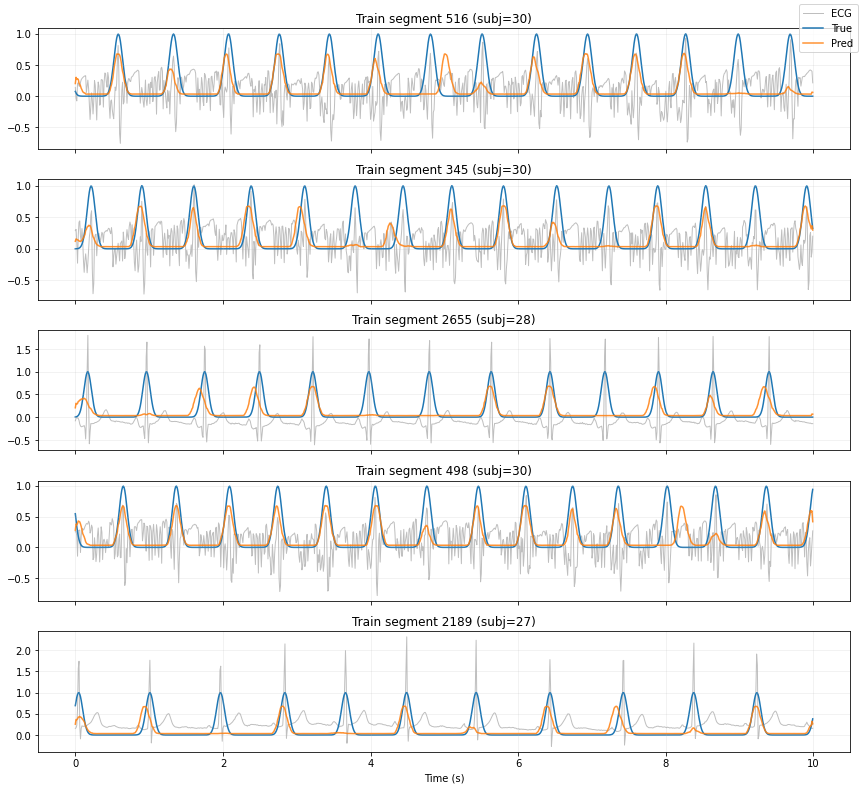

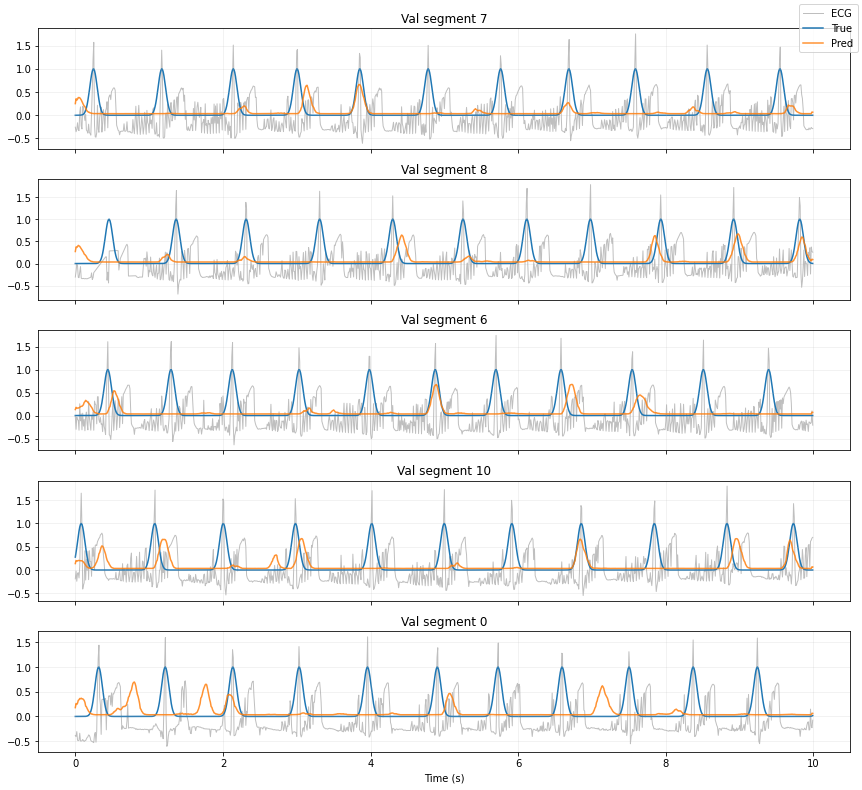

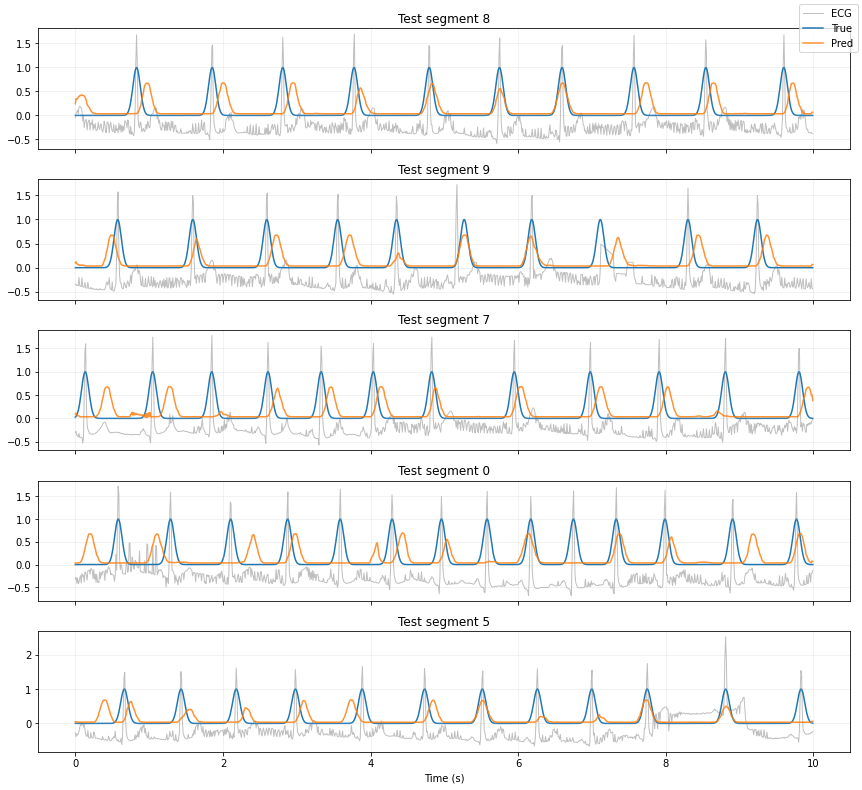

In [46]:
visualize_predictions('Train', X_train, y_train, ECG_train, model, seg_len, downsampled_frequency, device, train_seg_subjects, k=5)
visualize_predictions('Val', X_val, y_val, ECG_val, model, seg_len, downsampled_frequency, device, k=5)
visualize_predictions('Test', X_test, y_test, ECG_test, model, seg_len, downsampled_frequency, device, k=5)

In [47]:
# Per-subject training MAE
subject_mae(model, train_seg_subjects, X_train, y_train, device)

# Final evaluation
val_loss, val_mae = evaluate_loader(model, val_loader, device, criterion)
test_loss, test_mae = evaluate_loader(model, test_loader, device, criterion)

print(f"\nFinal Results:")
print(f"  Val MAE:  {val_mae:.5f}")
print(f"  Test MAE: {test_mae:.5f}")


Per-subject Training MAE:
  Subject 23: MAE = 0.09918 (660 segments)
  Subject 23: MAE = 0.09918 (660 segments)
  Subject 27: MAE = 0.11488 (660 segments)
  Subject 27: MAE = 0.11488 (660 segments)


  Subject 28: MAE = 0.11549 (660 segments)
  Subject 30: MAE = 0.12966 (660 segments)
  Subject 30: MAE = 0.12966 (660 segments)
  Subject 39: MAE = 0.14967 (660 segments)
  Subject 39: MAE = 0.14967 (660 segments)
  Subject 40: MAE = 0.11834 (660 segments)

Final Results:
  Val MAE:  0.16392
  Test MAE: 0.17775
  Subject 40: MAE = 0.11834 (660 segments)

Final Results:
  Val MAE:  0.16392
  Test MAE: 0.17775


[Val] Peak timing MAE: 0.1784s | median: 0.1400s | p90: 0.3600s | Npeaks=58 | dist=40 smp
[Test] Peak timing MAE: 0.1352s | median: 0.1300s | p90: 0.2800s | Npeaks=114 | dist=40 smp


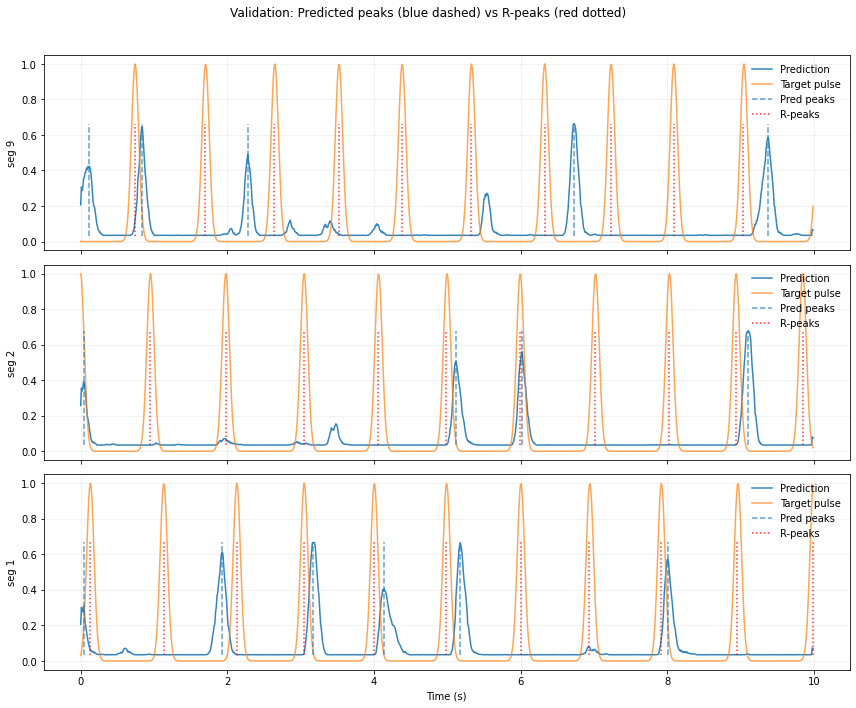

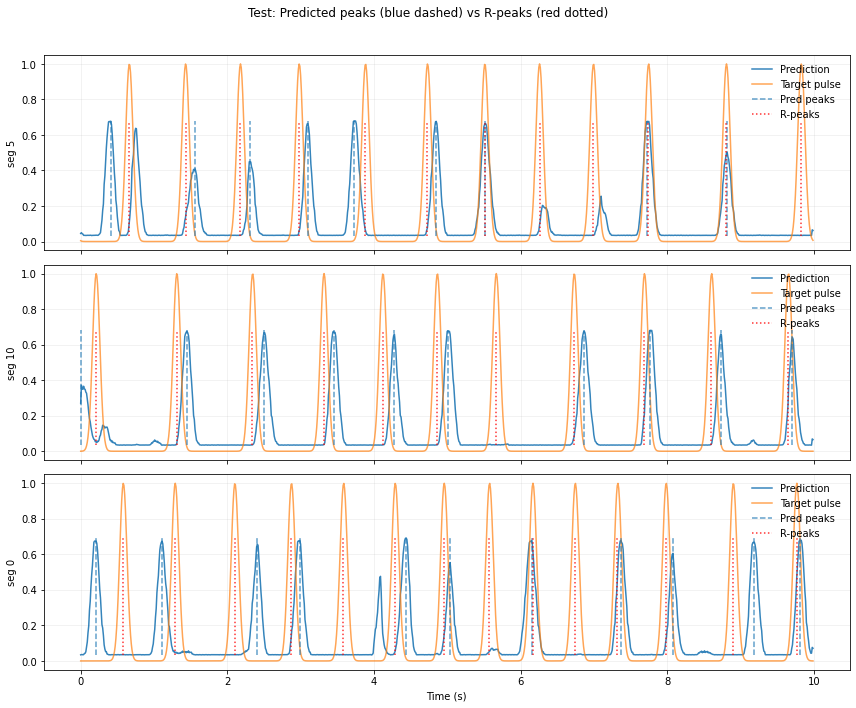

In [66]:
# Plot predicted peaks vs actual R-peaks on random val/test segments, and compute MAE for both
from scipy.signal import find_peaks

model.eval()

def nearest_diffs_samples(peaks_abs, r_abs):
    if peaks_abs.size == 0 or r_abs.size == 0:
        return np.empty((0,), dtype=float)
    diffs = []
    for p in peaks_abs:
        j = np.searchsorted(r_abs, p)
        cand = []
        if j < r_abs.size:
            cand.append(abs(r_abs[j] - p))
        if j > 0:
            cand.append(abs(r_abs[j - 1] - p))
        if cand:
            diffs.append(min(cand))
    return np.asarray(diffs, dtype=float)

def compute_peak_mae_for_set(X_set, rpeaks_abs, fs, seg_len, height=0.30, prominence=0.10, min_distance_s=0.4):
    min_distance_samples = max(1, int(min_distance_s * fs))
    all_diffs = []
    total_pred_peaks = 0
    with torch.no_grad():
        for i in range(X_set.shape[0]):
            xb = torch.from_numpy(X_set[i:i+1].astype(np.float32)).to(device)  # (1, T, C)
            pred = model(xb).squeeze(0).detach().cpu().numpy()  # (T,)
            peaks_pred, _ = find_peaks(pred, distance=min_distance_samples, height=height, prominence=prominence)
            total_pred_peaks += int(peaks_pred.size)
            seg_start = i * seg_len
            peaks_abs = peaks_pred + seg_start
            diffs = nearest_diffs_samples(peaks_abs, rpeaks_abs)
            if diffs.size:
                all_diffs.append(diffs)
    if len(all_diffs) == 0:
        return None, total_pred_peaks, min_distance_samples
    diffs_cat = np.concatenate(all_diffs)
    stats = {
        'mae_sec': float(diffs_cat.mean() / fs),
        'median_sec': float(np.median(diffs_cat) / fs),
        'p90_sec': float(np.percentile(diffs_cat, 90) / fs)
    }
    return stats, total_pred_peaks, min_distance_samples

# Peak detection params (shared)
height = 0.30
prominence = 0.10
min_distance_s = 0.4

# Validation set stats
fs_val = int(data_preprocessed[val_subj]['freq'])
rpeaks_val_abs = np.asarray(data_preprocessed[val_subj]['R_peaks'], dtype=int)
val_stats, val_npk, val_min_dist = compute_peak_mae_for_set(
    X_val, rpeaks_val_abs, fs_val, seg_len, height=height, prominence=prominence, min_distance_s=min_distance_s
)
if val_stats is None:
    print("[Val] No predicted peaks found with current detection parameters.")
else:
    print(f"[Val] Peak timing MAE: {val_stats['mae_sec']:.4f}s | median: {val_stats['median_sec']:.4f}s | p90: {val_stats['p90_sec']:.4f}s | Npeaks={val_npk} | dist={val_min_dist} smp")

# Test set stats
fs_test = int(data_preprocessed[test_subj]['freq'])
rpeaks_test_abs = np.asarray(data_preprocessed[test_subj]['R_peaks'], dtype=int)
test_stats, test_npk, test_min_dist = compute_peak_mae_for_set(
    X_test, rpeaks_test_abs, fs_test, seg_len, height=height, prominence=prominence, min_distance_s=min_distance_s
)
if test_stats is None:
    print("[Test] No predicted peaks found with current detection parameters.")
else:
    print(f"[Test] Peak timing MAE: {test_stats['mae_sec']:.4f}s | median: {test_stats['median_sec']:.4f}s | p90: {test_stats['p90_sec']:.4f}s | Npeaks={test_npk} | dist={test_min_dist} smp")

# Random segments plotting helper
def plot_random_segments(X_set, y_set, rpeaks_abs, fs, title_prefix, K=3):
    if X_set.shape[0] == 0:
        print(f"[Plot] {title_prefix}: empty set, nothing to plot.")
        return
    min_distance_samples = max(1, int(min_distance_s * fs))
    Kp = min(K, X_set.shape[0])
    rng = np.random.default_rng()
    seg_indices = rng.choice(X_set.shape[0], size=Kp, replace=False)
    t_seg = np.arange(seg_len) / fs
    fig, axes = plt.subplots(Kp, 1, figsize=(12, 3.2 * Kp), sharex=True)
    if Kp == 1:
        axes = [axes]
    with torch.no_grad():
        for ax, i in zip(axes, seg_indices):
            xb = torch.from_numpy(X_set[i:i+1].astype(np.float32)).to(device)
            pred = model(xb).squeeze(0).detach().cpu().numpy()  # (T,)
            y_gt = y_set[i]
            peaks_pred, _ = find_peaks(pred, distance=min_distance_samples, height=height, prominence=prominence)
            seg_start = i * seg_len
            seg_end = seg_start + pred.shape[0]
            in_seg = (rpeaks_abs >= seg_start) & (rpeaks_abs < seg_end)
            rpeaks_rel = (rpeaks_abs[in_seg] - seg_start).astype(int)
            ax.plot(t_seg, pred, label='Prediction', color='C0', alpha=0.9)
            ax.plot(t_seg, y_gt, label='Target pulse', color='C1', alpha=0.7)
            if peaks_pred.size:
                ax.vlines(t_seg[peaks_pred], ymin=np.min(pred), ymax=np.max(pred), color='C0', linestyles='dashed', alpha=0.7, label='Pred peaks')
            if rpeaks_rel.size:
                ax.vlines(t_seg[rpeaks_rel], ymin=np.min(pred), ymax=np.max(pred), color='r', linestyles='dotted', alpha=0.8, label='R-peaks')
            ax.set_ylabel(f"seg {i}")
            ax.grid(True, alpha=0.2)
            ax.legend(loc='upper right', frameon=False)
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(f"{title_prefix}: Predicted peaks (blue dashed) vs R-peaks (red dotted)", y=1.02)
    plt.tight_layout()
    plt.show()

# Plot random validation and test segments (different each run)
plot_random_segments(X_val, y_val, rpeaks_val_abs, fs_val, title_prefix='Validation')
plot_random_segments(X_test, y_test, rpeaks_test_abs, fs_test, title_prefix='Test')